In [2]:
!pip install easytorch

In [12]:
from easytorch import EasyTorch, ETRunner, ConfusionMatrix, ETMeter, AUCROCMetrics
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import torch
from IPython.display import Image

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

**Define neural network. I just burrowed from here: https://github.com/pytorch/examples/blob/master/mnist/main.py**

In [14]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [15]:

class MNISTTrainer(ETRunner):
    def _init_nn_model(self):
        self.nn['model'] = MNISTNet()

    def iteration(self, batch):
        inputs = batch[0].to(self.device['gpu']).float()
        labels = batch[1].to(self.device['gpu']).long()

        out = self.nn['model'](inputs)
        loss = F.nll_loss(out, labels)

        max_prob, pred = torch.max(out, 1)

        meter = self.new_meter()
        meter.averages.add(loss.item(), len(inputs))

        # Add extra loss if needed as:
        meter.averages.add(loss.item() * 0.3, len(inputs), index=1)

        meter.metrics['cmf'].add(pred, labels.float())
        meter.metrics['auc'].add(max_prob, labels.float())

        return {'loss': loss, 'meter': meter, 'predictions': pred}

    def init_cache(self):
        self.cache['log_header'] = 'Loss1,Loss2|Accuracy,F1,Precision,Recall'
        self.cache.update(monitor_metric='f1', metric_direction='maximize')

    def new_meter(self):
        return ETMeter(
            num_averages=2,  # Since we are tracing two losses
            cmf=ConfusionMatrix(num_classes=10),
            auc=AUCROCMetrics()
        )

In [16]:
train_dataset = datasets.MNIST('../data', train=True, download=True,
                               transform=transform)
val_dataset = datasets.MNIST('../data', train=False,
                             transform=transform)

In [18]:
dataloader_args = {'train': {'dataset': train_dataset},
                   'validation': {'dataset': val_dataset}}
runner = EasyTorch(phase='train', distributed_validation=True,
                   batch_size=512, epochs=21,
                   dataloader_args=dataloader_args,
                   image_size=(28, 28))
runner.run(MNISTTrainer)

[WARNING]! 1 GPU(s) requested but GPU(s) not detected. Using CPU(Much slower).
Starting with the following parameters:
{'batch_size': 128,
 'dataset_dir': '',
 'epochs': 5,
 'force': False,
 'gpus': [],
 'grad_accum_iters': 1,
 'is_master': True,
 'learning_rate': 0.001,
 'load_limit': None,
 'load_sparse': False,
 'log_dir': 'net_logs',
 'num_folds': None,
 'num_workers': 0,
 'patience': None,
 'phase': 'train',
 'pin_memory': False,
 'pretrained_path': None,
 'seed': 1471585,
 'seed_all': False,
 'split_ratio': None,
 'use_ddp': False,
 'verbose': True}
1 split(s) loaded from 'net_logs/experiment/splits' directory.
[SUCCESS]! Total params in model: 1199882
Training ...
Ep:1/5,Itr:1/469, Averages:[4.73507], Metrics:[0.14062, 0.1272, 0.14497, 0.11331]
Ep:1/5,Itr:2/469, Averages:[13.15077], Metrics:[0.07812, 0.04356, 0.10707, 0.02734]
Ep:1/5,Itr:3/469, Averages:[7.89299], Metrics:[0.19531, 0.19356, 0.17931, 0.21027]
Ep:1/5,Itr:4/469, Averages:[5.66375], Metrics:[0.21094, 0.13937, 0.1953

Ep:1/5,Itr:92/469, Averages:[0.54911], Metrics:[0.78125, 0.78441, 0.77593, 0.79307]
Ep:1/5,Itr:93/469, Averages:[0.58628], Metrics:[0.79688, 0.79691, 0.80056, 0.7933]
Ep:1/5,Itr:94/469, Averages:[0.63839], Metrics:[0.82812, 0.82288, 0.8236, 0.82216]
Ep:1/5,Itr:95/469, Averages:[0.58461], Metrics:[0.8125, 0.81357, 0.82185, 0.80546]
Ep:1/5,Itr:96/469, Averages:[0.47353], Metrics:[0.84375, 0.84864, 0.84465, 0.85267]
Ep:1/5,Itr:97/469, Averages:[0.6453], Metrics:[0.82812, 0.83009, 0.83477, 0.82546]
Ep:1/5,Itr:98/469, Averages:[0.45219], Metrics:[0.83594, 0.83489, 0.83176, 0.83805]
Ep:1/5,Itr:99/469, Averages:[0.51156], Metrics:[0.85156, 0.85481, 0.85339, 0.85623]
Ep:1/5,Itr:100/469, Averages:[0.46599], Metrics:[0.85938, 0.86827, 0.87323, 0.86338]
Ep:1/5,Itr:101/469, Averages:[0.55356], Metrics:[0.82031, 0.824, 0.82203, 0.82598]
Ep:1/5,Itr:102/469, Averages:[0.58705], Metrics:[0.80469, 0.81142, 0.79561, 0.82788]
Ep:1/5,Itr:103/469, Averages:[0.3618], Metrics:[0.90625, 0.9059, 0.91042, 0.901

Ep:1/5,Itr:191/469, Averages:[0.24046], Metrics:[0.92969, 0.92149, 0.92497, 0.91804]
Ep:1/5,Itr:192/469, Averages:[0.26319], Metrics:[0.89844, 0.91379, 0.92388, 0.90392]
Ep:1/5,Itr:193/469, Averages:[0.23744], Metrics:[0.92969, 0.93222, 0.92466, 0.9399]
Ep:1/5,Itr:194/469, Averages:[0.28686], Metrics:[0.89062, 0.87812, 0.88451, 0.87183]
Ep:1/5,Itr:195/469, Averages:[0.40528], Metrics:[0.875, 0.8798, 0.87557, 0.88408]
Ep:1/5,Itr:196/469, Averages:[0.2417], Metrics:[0.90625, 0.9065, 0.88913, 0.92458]
Ep:1/5,Itr:197/469, Averages:[0.24935], Metrics:[0.94531, 0.93976, 0.9371, 0.94245]
Ep:1/5,Itr:198/469, Averages:[0.52739], Metrics:[0.875, 0.88509, 0.8801, 0.89014]
Ep:1/5,Itr:199/469, Averages:[0.29536], Metrics:[0.90625, 0.89515, 0.89422, 0.89609]
Ep:1/5,Itr:200/469, Averages:[0.36324], Metrics:[0.88281, 0.89039, 0.89393, 0.88688]
Ep:1/5,Itr:201/469, Averages:[0.29965], Metrics:[0.90625, 0.90286, 0.90767, 0.8981]
Ep:1/5,Itr:202/469, Averages:[0.20859], Metrics:[0.92969, 0.92758, 0.92469, 

Ep:1/5,Itr:290/469, Averages:[0.17863], Metrics:[0.92188, 0.92007, 0.92005, 0.92009]
Ep:1/5,Itr:291/469, Averages:[0.12605], Metrics:[0.95312, 0.951, 0.95314, 0.94886]
Ep:1/5,Itr:292/469, Averages:[0.1376], Metrics:[0.96094, 0.96326, 0.96357, 0.96295]
Ep:1/5,Itr:293/469, Averages:[0.20592], Metrics:[0.92188, 0.92611, 0.9271, 0.92512]
Ep:1/5,Itr:294/469, Averages:[0.20144], Metrics:[0.92188, 0.90404, 0.90075, 0.90736]
Ep:1/5,Itr:295/469, Averages:[0.19335], Metrics:[0.92188, 0.92258, 0.93026, 0.91502]
Ep:1/5,Itr:296/469, Averages:[0.21399], Metrics:[0.90625, 0.91481, 0.91518, 0.91444]
Ep:1/5,Itr:297/469, Averages:[0.26538], Metrics:[0.9375, 0.93954, 0.94308, 0.93602]
Ep:1/5,Itr:298/469, Averages:[0.16865], Metrics:[0.95312, 0.95445, 0.95759, 0.95134]
Ep:1/5,Itr:299/469, Averages:[0.18573], Metrics:[0.92969, 0.9261, 0.93398, 0.91836]
Ep:1/5,Itr:300/469, Averages:[0.17901], Metrics:[0.94531, 0.94197, 0.93731, 0.94668]
Ep:1/5,Itr:301/469, Averages:[0.373], Metrics:[0.89062, 0.89604, 0.8993

Ep:1/5,Itr:389/469, Averages:[0.39967], Metrics:[0.90625, 0.90403, 0.89969, 0.90841]
Ep:1/5,Itr:390/469, Averages:[0.23674], Metrics:[0.9375, 0.93609, 0.93896, 0.93322]
Ep:1/5,Itr:391/469, Averages:[0.15213], Metrics:[0.94531, 0.94755, 0.94988, 0.94524]
Ep:1/5,Itr:392/469, Averages:[0.23582], Metrics:[0.92188, 0.92336, 0.92483, 0.9219]
Ep:1/5,Itr:393/469, Averages:[0.17773], Metrics:[0.9375, 0.939, 0.92774, 0.95054]
Ep:1/5,Itr:394/469, Averages:[0.0819], Metrics:[0.98438, 0.98513, 0.98462, 0.98565]
Ep:1/5,Itr:395/469, Averages:[0.28701], Metrics:[0.91406, 0.91733, 0.91162, 0.92311]
Ep:1/5,Itr:396/469, Averages:[0.18216], Metrics:[0.95312, 0.95113, 0.94917, 0.95309]
Ep:1/5,Itr:397/469, Averages:[0.22939], Metrics:[0.92188, 0.92474, 0.92663, 0.92286]
Ep:1/5,Itr:398/469, Averages:[0.13355], Metrics:[0.96094, 0.96, 0.9666, 0.95349]
Ep:1/5,Itr:399/469, Averages:[0.13127], Metrics:[0.96094, 0.95675, 0.95274, 0.96079]
Ep:1/5,Itr:400/469, Averages:[0.11954], Metrics:[0.96875, 0.96553, 0.95481,

 Itr:21/79, Averages:[0.09337], Metrics:[0.98438, 0.98337, 0.98444, 0.98231]
 Itr:22/79, Averages:[0.03755], Metrics:[0.99219, 0.9873, 0.98571, 0.98889]
 Itr:23/79, Averages:[0.11812], Metrics:[0.96875, 0.96803, 0.97104, 0.96503]
 Itr:24/79, Averages:[0.08618], Metrics:[0.95312, 0.95561, 0.95636, 0.95487]
 Itr:25/79, Averages:[0.02976], Metrics:[0.99219, 0.99199, 0.99167, 0.99231]
 Itr:26/79, Averages:[0.05422], Metrics:[0.97656, 0.97042, 0.97786, 0.9631]
 Itr:27/79, Averages:[0.02166], Metrics:[0.99219, 0.99236, 0.99474, 0.99]
 Itr:28/79, Averages:[0.14174], Metrics:[0.96875, 0.96839, 0.96836, 0.96841]
 Itr:29/79, Averages:[0.05855], Metrics:[0.99219, 0.98875, 0.99, 0.9875]
 Itr:30/79, Averages:[0.19542], Metrics:[0.94531, 0.94749, 0.94762, 0.94736]
 Itr:31/79, Averages:[0.1232], Metrics:[0.96094, 0.95736, 0.96099, 0.95375]
 Itr:32/79, Averages:[0.09487], Metrics:[0.96094, 0.9575, 0.96532, 0.94981]
 Itr:33/79, Averages:[0.05595], Metrics:[0.98438, 0.98527, 0.98755, 0.98301]
 Itr:34/79

Ep:2/5,Itr:140/469, Averages:[0.13673], Metrics:[0.96094, 0.96027, 0.96053, 0.96]
Ep:2/5,Itr:144/469, Averages:[0.1361], Metrics:[0.96289, 0.96139, 0.9603, 0.96248]
Ep:2/5,Itr:148/469, Averages:[0.11312], Metrics:[0.97266, 0.97291, 0.97282, 0.973]
Ep:2/5,Itr:152/469, Averages:[0.15578], Metrics:[0.94922, 0.94988, 0.94969, 0.95006]
Ep:2/5,Itr:156/469, Averages:[0.18078], Metrics:[0.94727, 0.94713, 0.9468, 0.94746]
Ep:2/5,Itr:160/469, Averages:[0.16733], Metrics:[0.94922, 0.95014, 0.94984, 0.95045]
Ep:2/5,Itr:164/469, Averages:[0.16046], Metrics:[0.94922, 0.94948, 0.94948, 0.94948]
Ep:2/5,Itr:168/469, Averages:[0.13905], Metrics:[0.95312, 0.95154, 0.95164, 0.95144]
Ep:2/5,Itr:172/469, Averages:[0.12592], Metrics:[0.96094, 0.96107, 0.96057, 0.96157]
Ep:2/5,Itr:176/469, Averages:[0.13386], Metrics:[0.95508, 0.95527, 0.95488, 0.95567]
Ep:2/5,Itr:180/469, Averages:[0.12832], Metrics:[0.96094, 0.96114, 0.96153, 0.96075]
Ep:2/5,Itr:184/469, Averages:[0.16827], Metrics:[0.94922, 0.94991, 0.9496

 Itr:63/79, Averages:[0.02539], Metrics:[0.99219, 0.99226, 0.99167, 0.99286]
 Itr:66/79, Averages:[0.04825], Metrics:[0.98438, 0.98327, 0.98231, 0.98424]
 Itr:69/79, Averages:[0.00011], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:72/79, Averages:[0.00032], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:75/79, Averages:[0.0104], Metrics:[0.99219, 0.99188, 0.99286, 0.99091]
 Itr:76/79, Averages:[0.11455], Metrics:[0.96094, 0.96311, 0.95814, 0.96814]
[SUCCESS]! experiment validation Averages:[0.05177], Metrics:[0.9841, 0.98411, 0.98413, 0.9841]
[SUCCESS]!  *** Best Model Saved!!! *** : 0.9841129687961727
Ep:3/5,Itr:1/469, Averages:[0.09829], Metrics:[0.96875, 0.96841, 0.97378, 0.96309]
Ep:3/5,Itr:2/469, Averages:[0.13452], Metrics:[0.96094, 0.96746, 0.96944, 0.96549]
Ep:3/5,Itr:4/469, Averages:[0.13735], Metrics:[0.94531, 0.94342, 0.94272, 0.94412]
Ep:3/5,Itr:6/469, Averages:[0.06422], Metrics:[0.97656, 0.97633, 0.97551, 0.97715]
Ep:3/5,Itr:9/469, Averages:[0.09757], Metrics:[0.97396, 0.97244, 0.97109, 0.9738]


 Itr:28/79, Averages:[0.09753], Metrics:[0.96875, 0.96902, 0.97067, 0.96738]
 Itr:32/79, Averages:[0.07047], Metrics:[0.96875, 0.96449, 0.9712, 0.95787]
 Itr:36/79, Averages:[0.09887], Metrics:[0.97656, 0.9759, 0.97348, 0.97833]
 Itr:40/79, Averages:[0.00585], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:45/79, Averages:[0.00977], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:50/79, Averages:[6.e-05], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:55/79, Averages:[0.00228], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:60/79, Averages:[0.00073], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:65/79, Averages:[0.02355], Metrics:[0.99219, 0.99017, 0.99286, 0.9875]
 Itr:70/79, Averages:[0.00032], Metrics:[1.0, 1.0, 1.0, 1.0]
 Itr:75/79, Averages:[0.00984], Metrics:[0.99219, 0.99188, 0.99286, 0.99091]
[SUCCESS]! experiment validation Averages:[0.03836], Metrics:[0.9872, 0.98715, 0.98714, 0.98716]
[SUCCESS]!  *** Best Model Saved!!! *** : 0.9871485232042972
Ep:4/5,Itr:1/469, Averages:[0.10441], Metrics:[0.96875, 0.96988, 0.9671, 0.97268]
Ep:4/5,Itr:2/

Ep:5/5,Itr:12/469, Averages:[0.08535], Metrics:[0.97852, 0.9773, 0.97684, 0.97776]
Ep:5/5,Itr:15/469, Averages:[0.07203], Metrics:[0.97396, 0.97458, 0.97696, 0.97221]
Ep:5/5,Itr:20/469, Averages:[0.04695], Metrics:[0.98906, 0.98932, 0.9893, 0.98933]
Ep:5/5,Itr:24/469, Averages:[0.07766], Metrics:[0.98438, 0.98462, 0.98446, 0.98479]
Ep:5/5,Itr:30/469, Averages:[0.05388], Metrics:[0.98568, 0.98569, 0.98594, 0.98544]
Ep:5/5,Itr:36/469, Averages:[0.05982], Metrics:[0.98047, 0.98004, 0.97974, 0.98034]
Ep:5/5,Itr:42/469, Averages:[0.05551], Metrics:[0.98307, 0.98233, 0.98206, 0.9826]
Ep:5/5,Itr:49/469, Averages:[0.05329], Metrics:[0.98549, 0.98519, 0.98512, 0.98525]
Ep:5/5,Itr:56/469, Averages:[0.08934], Metrics:[0.97321, 0.9734, 0.97417, 0.97263]
Ep:5/5,Itr:63/469, Averages:[0.07748], Metrics:[0.98103, 0.98074, 0.97983, 0.98166]
Ep:5/5,Itr:70/469, Averages:[0.08272], Metrics:[0.97768, 0.97765, 0.97823, 0.97707]
Ep:5/5,Itr:77/469, Averages:[0.07239], Metrics:[0.97656, 0.97656, 0.97645, 0.976

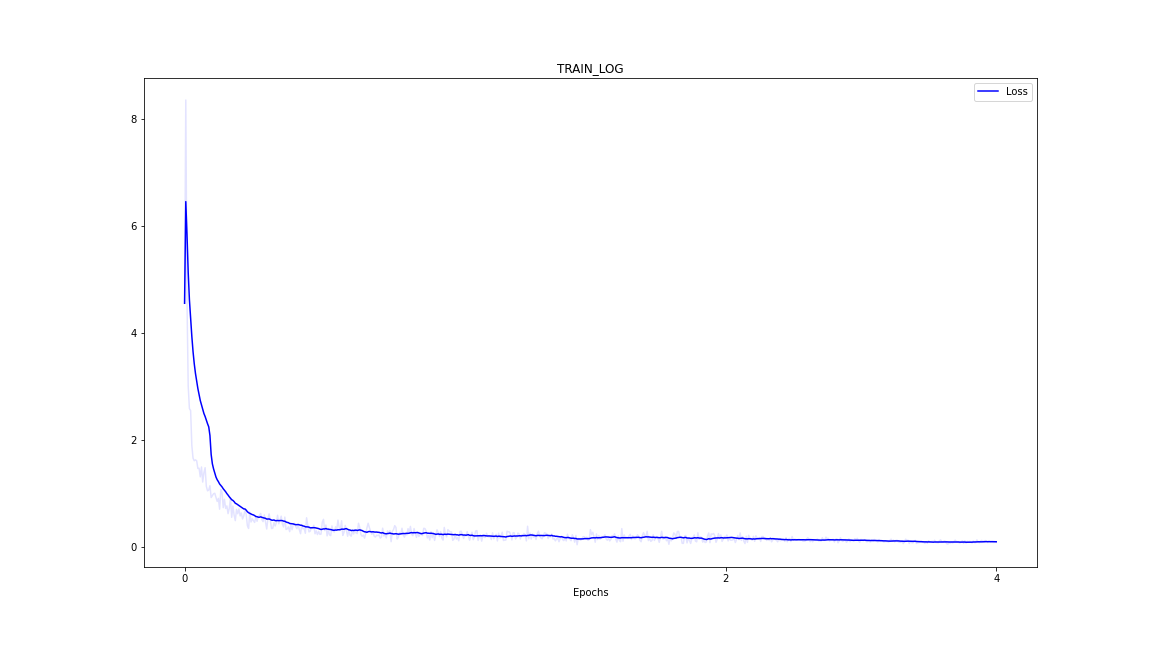

In [7]:
Image('net_logs/experiment/experiment_train_log_0.png')

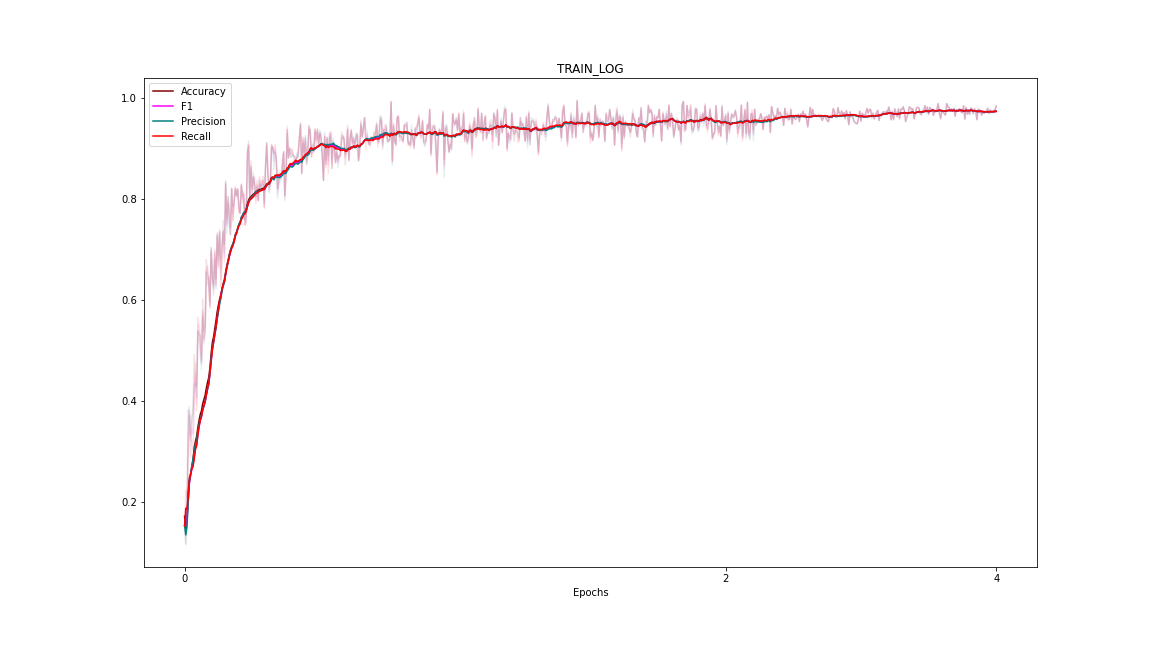

In [8]:
Image('net_logs/experiment/experiment_train_log_1.png')

### Saved logs

In [9]:
import json
import pprint as ppr

In [10]:
log = json.loads(open('net_logs/experiment/experiment_log.json').read())

In [11]:
log

{'phase': 'train',
 'batch_size': 128,
 'epochs': 3,
 'grad_accum_iters': 1,
 'learning_rate': 0.001,
 'gpus': [],
 'pin_memory': False,
 'num_workers': 0,
 'dataset_dir': '',
 'load_limit': None,
 'log_dir': 'net_logs/experiment',
 'pretrained_path': None,
 'verbose': True,
 'seed_all': False,
 'force': False,
 'patience': None,
 'load_sparse': False,
 'num_folds': None,
 'split_ratio': None,
 'seed': 9500374,
 'global_test_metrics': [],
 'log_header': 'Loss|Accuracy,F1,Precision,Recall',
 'monitor_metric': 'f1',
 'metric_direction': 'maximize',
 'train_log': [[4.55726, 0.17188, 0.15343, 0.15437, 0.15251],
  [8.36324, 0.11719, 0.15221, 0.11551, 0.22307],
  [4.6089, 0.20312, 0.18334, 0.18453, 0.18216],
  [3.00693, 0.38281, 0.31471, 0.3559, 0.28206],
  [2.58417, 0.36719, 0.38099, 0.38982, 0.37256],
  [2.54765, 0.28906, 0.32768, 0.33277, 0.32274],
  [1.89565, 0.35938, 0.34514, 0.36923, 0.324],
  [1.65683, 0.39062, 0.33505, 0.37506, 0.30275],
  [1.60825, 0.49219, 0.41763, 0.43247, 0.40379